In [89]:
import numpy as np
import matplotlib.pyplot as plt
import random
import plotly.graph_objects as go
from scipy.stats import skew, kurtosis

from matplotlib.ticker import LogLocator 
from scipy.special import factorial
from scipy.optimize import curve_fit

In [90]:
def load_data(path):
  data = []
  
  with open(path, 'r') as file:
    for _ in range(5):
      next(file)

    for line in file:
      columns = line.split(";")
      data.append(int(columns[0]))
      
  data = np.array(data)
  data = data - data[0]
    
  return data

In [91]:
spinning0 = load_data("Data/Spinning_wheel/Part_0.txt")
spinning1 = load_data("Data/Spinning_wheel/Part_1.txt")
spinning2 = load_data("Data/Spinning_wheel/Part_2.txt")
spinning_old = load_data("Data/Spinning_wheel/Old.txt")

static0 = load_data("Data/Static_wheel/Part_0.txt")
static1 = load_data("Data/Static_wheel/Part_1.txt")
static2 = load_data("Data/Static_wheel/Part_2.txt")

In [92]:
norm_data1 = np.diff(static0)
norm_data2 = np.diff(spinning_old)

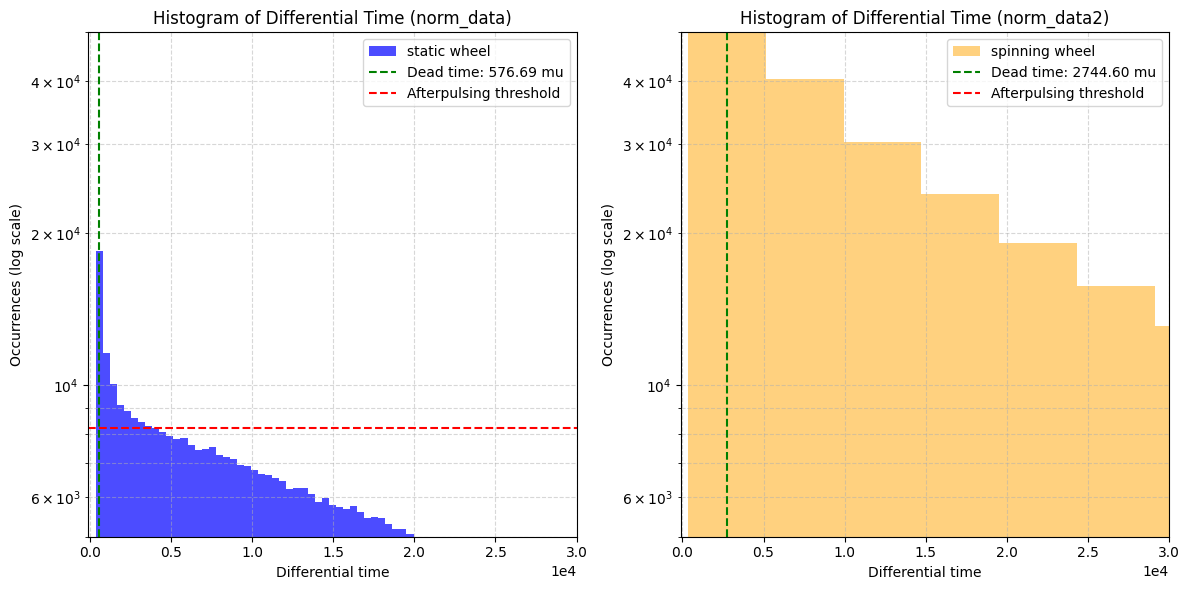

Dead time static: 4.6711647000000005e-08
Dead time spinning: 2.2231276199999997e-07


In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First histogram (norm_data) in the first subplot
counts1, bin_edges1, _ = ax1.hist(norm_data1, bins=1000, log=True, color="blue", alpha=0.7, label="static wheel")
first_bin_center1 = (bin_edges1[0] + bin_edges1[1]) / 2
ax1.axvline(first_bin_center1, color="green", linestyle="--", label=f"Dead time: {first_bin_center1:.2f} mu")
bin_index1 = np.digitize(3900, bin_edges1) - 1
if 0 <= bin_index1 < len(counts1):
    bin_height1 = counts1[bin_index1]
    ax1.axhline(y=bin_height1, color="red", linestyle="--", label="Afterpulsing threshold")
ax1.set_xlabel("Differential time")
ax1.set_ylabel("Occurrences (log scale)")
ax1.set_title("Histogram of Differential Time (norm_data)")
ax1.grid(which="both", linestyle="--", alpha=0.5)
ax1.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax1.ticklabel_format(style="scientific", axis="x", scilimits=(0, 0))
ax1.legend()
ax1.set_xlim(-100, 30000)
ax1.set_ylim(5000, 50000)

# Second histogram (norm_data2) in the second subplot
counts2, bin_edges2, _ = ax2.hist(norm_data2, bins=1000, log=True, color="orange", alpha=0.5, label="spinning wheel")
first_bin_center2 = (bin_edges2[0] + bin_edges2[1]) / 2
ax2.axvline(first_bin_center2, color="green", linestyle="--", label=f"Dead time: {first_bin_center2:.2f} mu")
bin_index2 = np.digitize(3900, bin_edges2) - 1
if 0 <= bin_index2 < len(counts2):
    bin_height2 = counts2[bin_index2]
    ax2.axhline(y=bin_height2, color="red", linestyle="--", label="Afterpulsing threshold")
ax2.set_xlabel("Differential time")
ax2.set_ylabel("Occurrences (log scale)")
ax2.set_title("Histogram of Differential Time (norm_data2)")
ax2.grid(which="both", linestyle="--", alpha=0.5)
ax2.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax2.ticklabel_format(style="scientific", axis="x", scilimits=(0, 0))
ax2.legend()
ax2.set_xlim(-100, 30000)
ax2.set_ylim(5000, 50000)

plt.tight_layout()
plt.show()

print(f"Dead time static: {first_bin_center1 * 81 * 1E-12}")
print(f"Dead time spinning: {first_bin_center2 * 81 * 1E-12}")

In [224]:
counts1 = counts1[bin_index1:]
bin_edges1 = bin_edges1[bin_index1:]
bin_edges1 = bin_edges1 - bin_edges1[0] - 0.5

counts2 = counts2[bin_index2:]
bin_edges2 = bin_edges2[bin_index2:]
bin_edges2 = bin_edges2 - bin_edges2[0] - 0.5

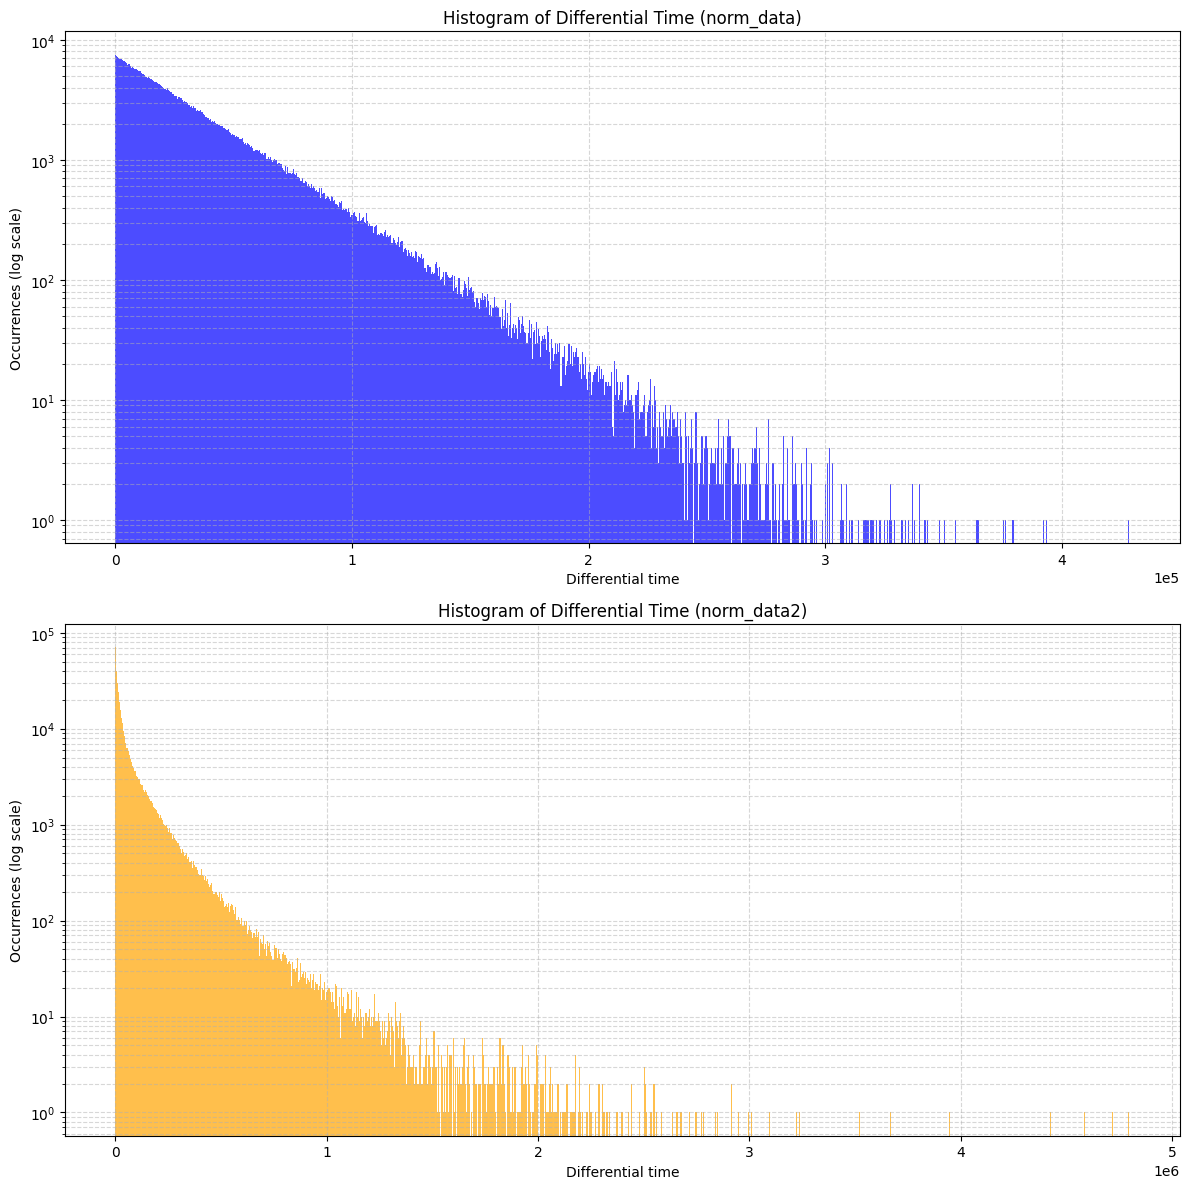

In [226]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# First histogram (norm_data)
ax1.hist(bin_edges1[:-1], bins=bin_edges1, weights=counts1, log=True, color='blue', alpha=0.7)
ax1.set_xlabel('Differential time')
ax1.set_ylabel('Occurrences (log scale)')
ax1.set_title('Histogram of Differential Time (norm_data)')
ax1.grid(which='both', linestyle='--', alpha=0.5)
ax1.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax1.ticklabel_format(style="scientific", axis="x", scilimits=(0, 0))

# Second histogram (norm_data2)
ax2.hist(bin_edges2[:-1], bins=bin_edges2, weights=counts2, log=True, color='orange', alpha=0.7)
ax2.set_xlabel('Differential time')
ax2.set_ylabel('Occurrences (log scale)')
ax2.set_title('Histogram of Differential Time (norm_data2)')
ax2.grid(which='both', linestyle='--', alpha=0.5)
ax2.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax2.ticklabel_format(style="scientific", axis="x", scilimits=(0, 0))

plt.tight_layout()
plt.show()

In [96]:
def counter(data, threshold):
  counts = []
  total_time = 0
  count = 0

  for time in data:
      total_time += time

      if total_time <= threshold:
          count += 1
      else:
          counts.append(count)
          total_time = 0
          count = 0

  if count > 0:
      counts.append(count)

  return np.array(counts)

In [97]:
deltaT = 10e6 / 81
count_static = counter(norm_data1, deltaT)
count_spinning = counter(norm_data2, deltaT)

print(max(count_static))
print(max(count_spinning))

16
51


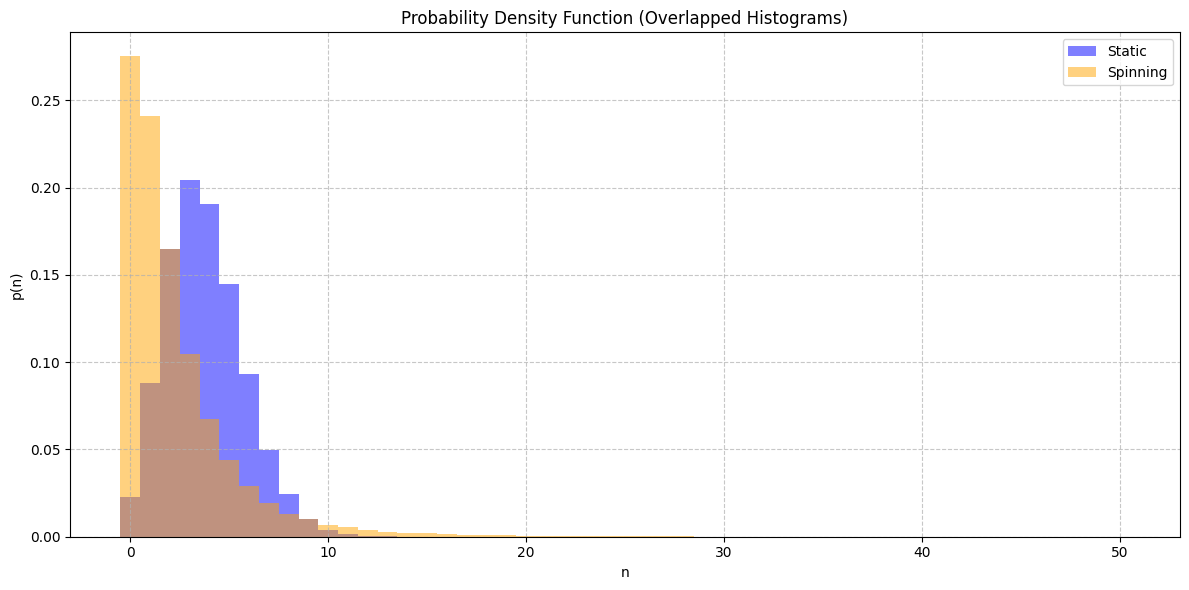

In [222]:
plt.figure(figsize=(12, 6))

plt.hist(count_static, bins=np.arange(-0.5, max(count_static)), density=True, color='blue', alpha=0.5, label='Static')
plt.hist(count_spinning, bins=np.arange(-0.5, max(count_spinning)), density=True, color='orange', alpha=0.5, label='Spinning')

plt.xlabel('n')
plt.ylabel('p(n)')
plt.title('Probability Density Function (Overlapped Histograms)')

plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [198]:
def p_thermal(n, mean):
  return (1 / (mean + 1)) * (mean / (mean + 1))**n

def p_coherent(n, mean):
  return ((mean**n) * np.exp(-mean)) / factorial(n)

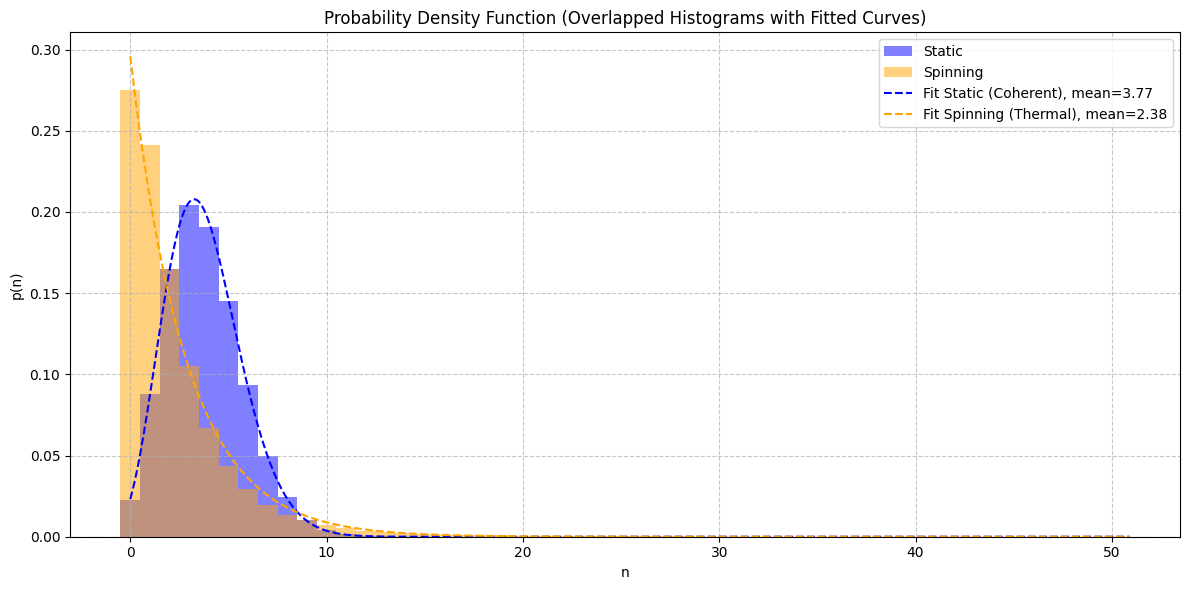

In [216]:
plt.figure(figsize=(12, 6))

counts_static, bin_edges_static, _ = plt.hist(count_static, bins=np.arange(-0.5, max(count_static)), density=True, color='blue', alpha=0.5, label='Static')
counts_spinning, bin_edges_spinning, _ = plt.hist(count_spinning, bins=np.arange(-0.5, max(count_spinning)), density=True, color='orange', alpha=0.5, label='Spinning')

bin_centers_static = (bin_edges_static[:-1] + bin_edges_static[1:]) / 2
bin_centers_spinning = (bin_edges_spinning[:-1] + bin_edges_spinning[1:]) / 2

popt_coherent_static, pcov_static = curve_fit(p_coherent, bin_centers_static, counts_static, p0=[1.0])
popt_thermal_spinning, pcov_spinning = curve_fit(p_thermal, bin_centers_spinning, counts_spinning, p0=[1.0])

mean_coherent_static = popt_coherent_static[0]
mean_thermal_spinning = popt_thermal_spinning[0]

n_vals_static = np.arange(0, max(count_spinning), 0.1)
n_vals_spinning = np.arange(0, max(count_spinning), 0.1)
plt.plot(n_vals_static, p_coherent(n_vals_static, mean_coherent_static), color='blue', linestyle='--', label=f'Fit Static (Coherent), mean={mean_coherent_static:.2f}')
plt.plot(n_vals_spinning, p_thermal(n_vals_spinning, mean_thermal_spinning), color='orange', linestyle='--', label=f'Fit Spinning (Thermal), mean={mean_thermal_spinning:.2f}')

plt.xlabel('n')
plt.ylabel('p(n)')
plt.title('Probability Density Function (Overlapped Histograms with Fitted Curves)')
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [237]:
print("Numerical statistics for static wheel:\n")
print(f"Mean: {np.mean(count_static)}")
print(f"Variance: {np.var(count_static)}")
print(f"Skewness: {skew(count_static) * np.mean(count_static) ** (3/2)}")
print(f"Kurtosis: {kurtosis(count_static, fisher = False) * np.mean(count_static) ** 2}")

print("\n\nNumerical statistics for spinning wheel:\n")
print(f"Mean: {np.mean(count_spinning)}")
print(f"Variance: {np.var(count_spinning)}")
print(f"Skewness: {skew(count_spinning) * np.mean(count_spinning) ** (3/2)}")
print(f"Kurtosis: {kurtosis(count_spinning, fisher = False) * np.mean(count_spinning) ** 2}")

Numerical statistics for static wheel:

Mean: 3.779037649839608
Variance: 3.848085989296655
Skewness: 3.9147160959661607
Kurtosis: 46.87150103049179


Numerical statistics for spinning wheel:

Mean: 2.3161389529600895
Variance: 9.186559272786852
Skewness: 11.494036660395578
Kurtosis: 115.38895802667741


In [239]:
print("Analytical statistics for static wheel:\n")
print(f"Mean: {popt_coherent_static[0]} +/- {pcov_static[0][0]}")
print(f"Variance: {popt_coherent_static[0]} +/- {pcov_static[0][0]}")
print(f"Skewness: {popt_coherent_static[0]} +/- {pcov_static[0][0]}")
print(f"Kurtosis: {popt_coherent_static[0] + 3 * popt_coherent_static[0]**2}")

print("\n\nAnalytical statistics for spinning wheel:\n")
print(f"Mean: {popt_thermal_spinning[0]} +/- {pcov_spinning[0][0]}")
print(f"Variance: {popt_thermal_spinning[0] + popt_thermal_spinning[0]**2}")
print(f"Skewness: {popt_thermal_spinning[0] + 3 * popt_thermal_spinning[0]**2 + 2 * popt_thermal_spinning[0]**3}")
print(f"Kurtosis: {popt_thermal_spinning[0] + 3 * popt_thermal_spinning[0]**2}")

Analytical statistics for static wheel:

Mean: 3.765646819275313 +/- 6.808724529743325e-05
Variance: 3.765646819275313 +/- 6.808724529743325e-05
Skewness: 3.765646819275313 +/- 6.808724529743325e-05
Kurtosis: 46.30593472183016


Analytical statistics for spinning wheel:

Mean: 0.1 +/- inf
Variance: 0.11000000000000001
Skewness: 0.132
Kurtosis: 0.13


# Quantum Random Number Generator

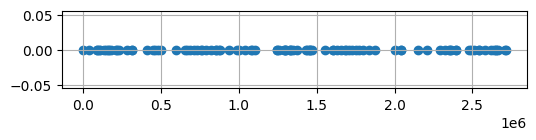

In [184]:
plt.figure(figsize=(6, 1))
plt.scatter(static0[:100], np.zeros(100))
plt.grid()
plt.show()

In [185]:
static0_diff = np.diff(static0)
static1_diff = np.diff(static1)
static2_diff = np.diff(static2)
static = np.concatenate((static0_diff, static1_diff, static2_diff))
static = static[static > 3900]

In [186]:
def bits_to_byte(bits):
  byte = 0
  for bit in bits:
    byte = (byte << 1) | bit
  return byte
  
def qrng_list(data):
  bits_list = []
  bytes_list = []
  i = 1
  while i < len(data):
    bits_list.append(int(data[i] > data[i-1]))
    i += 2

  bits_list = np.array(bits_list)
  
  for i in range(0, len(bits_list), 8):
    byte_chunk = bits_list[i:i+8]
    if len(byte_chunk) == 8:
      bytes_list.append(bits_to_byte(byte_chunk))
  
  return bytes_list

In [187]:
bytes_list = qrng_list(static)

with open("random/data/qrng.bin", "wb") as file:
  file.write(bytearray(bytes_list))

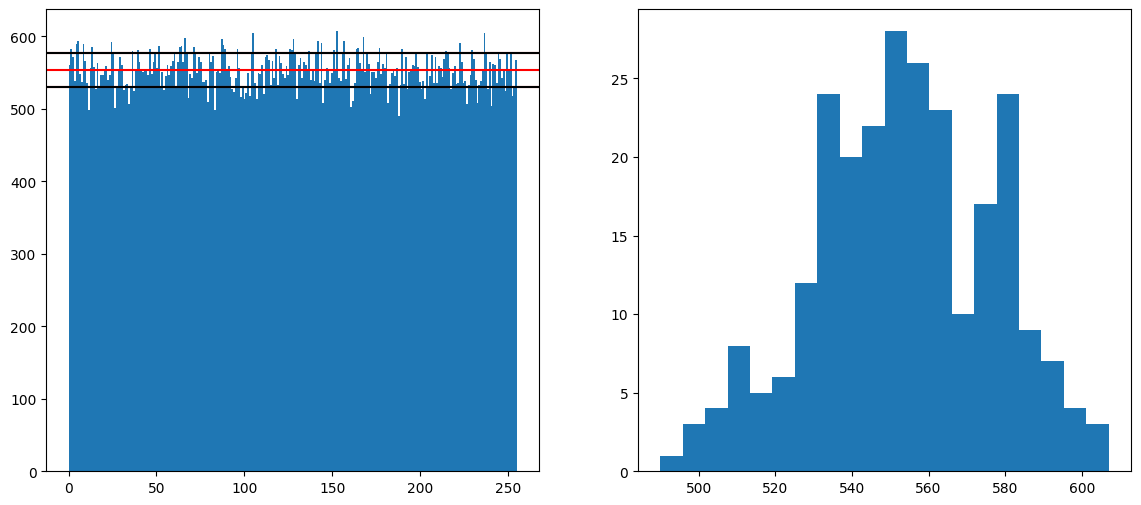

Bytes:
Mean: 127.32900680387341, Standard Deviation: 73.84631855171854

Counts:
Mean: 553.453125, Standard Deviation: 23.338494011704675


In [188]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

counts_qrng, bin_edges_qrng, _ = ax1.hist(bytes_list, bins=max(bytes_list)+1)
mean_qrng = np.mean(counts_qrng)
std_qrng = np.std(counts_qrng)

# Plotting mean and standard deviation lines
ax1.axhline(y=mean_qrng, color='r')
ax1.axhline(y=mean_qrng - std_qrng, color='r')
ax1.axhline(y=mean_qrng + std_qrng, color='r')
ax1.axhline(y=mean_qrng - np.sqrt(mean_qrng), color='k')
ax1.axhline(y=mean_qrng + np.sqrt(mean_qrng), color='k')

ax2.hist(counts_qrng, bins=20)

plt.show()

print(f'Bytes:\nMean: {np.mean(bytes_list)}, Standard Deviation: {np.std(bytes_list)}\n')
print(f'Counts:\nMean: {mean_qrng}, Standard Deviation: {std_qrng}')

In [189]:
colors = ['red', 'blue', 'green', 'orange', 'purple']
color_choices = []

x_vals = []
y_vals = []
z_vals = []

k = 0
while k < len(bytes_list) - 2:
  x_vals.append(bytes_list[k])
  y_vals.append(bytes_list[k+1])
  z_vals.append(bytes_list[k+2])
  color_choices.append(random.choice(colors))
  k += 3

fig = go.Figure(data=[go.Scatter3d(x=x_vals, y=y_vals, z=z_vals, mode='markers', marker=dict(size=2, color=color_choices, opacity=0.6))])

fig.update_layout(
  title="Interactive 3D Scatter Plot - QRNG",
  scene=dict(
    xaxis_title='X Axis',
    yaxis_title='Y Axis',
    zaxis_title='Z Axis'
  ),
  width=1000, height=1000
)

fig.show()

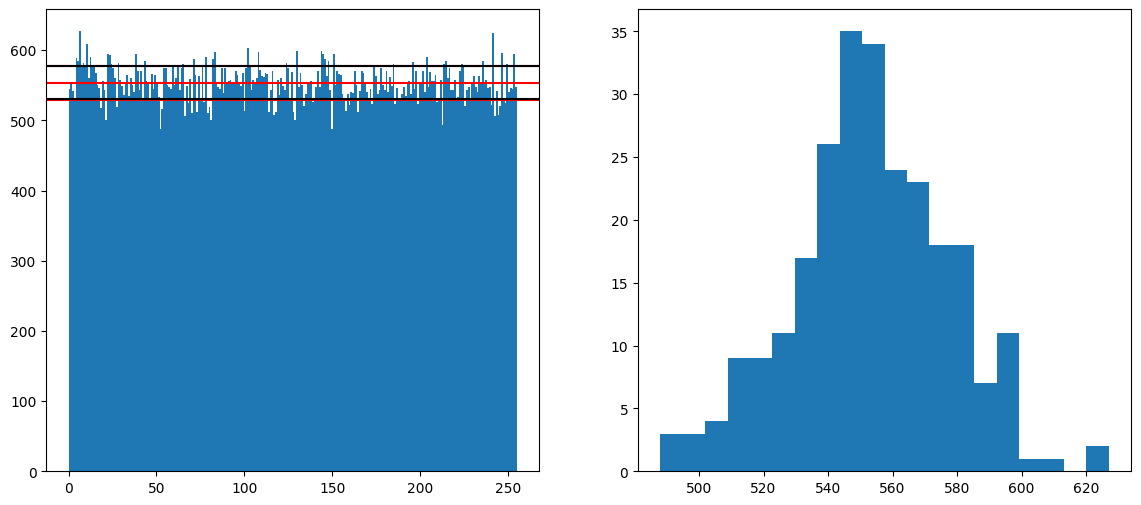

Bytes:
Mean: 127.09310154992801, Standard Deviation: 74.0365735558363

Counts:
Mean: 553.453125, Standard Deviation: 23.338494011704675


In [190]:
random_elements = np.random.choice(np.arange(256), size=len(bytes_list), replace=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

counts_prng, bin_edges_prng, _ = ax1.hist(random_elements, bins=max(random_elements)+1)
mean_prng = np.mean(counts_prng)
std_prng = np.std(counts_prng)

# Plotting mean and standard deviation lines
ax1.axhline(y=mean_prng, color='r')
ax1.axhline(y=mean_prng - std_prng, color='r')
ax1.axhline(y=mean_prng + std_prng, color='r')
ax1.axhline(y=mean_prng - np.sqrt(mean_prng), color='k')
ax1.axhline(y=mean_prng + np.sqrt(mean_prng), color='k')

ax2.hist(counts_prng, bins=20)

plt.show()

print(f'Bytes:\nMean: {np.mean(random_elements)}, Standard Deviation: {np.std(random_elements)}\n')
print(f'Counts:\nMean: {mean_qrng}, Standard Deviation: {std_qrng}')

In [191]:
with open("random/data/prng.bin", "wb") as file:
  file.write(bytearray(random_elements))

In [192]:
colors = ['red', 'blue', 'green', 'orange', 'purple']
color_choices = []

x_vals = []
y_vals = []
z_vals = []

k = 0
while k < len(random_elements) - 2:
  x_vals.append(random_elements[k])
  y_vals.append(random_elements[k+1])
  z_vals.append(random_elements[k+2])
  color_choices.append(random.choice(colors))
  k += 3

fig = go.Figure(data=[go.Scatter3d(x=x_vals, y=y_vals, z=z_vals, mode='markers', marker=dict(size=2, color=color_choices, opacity=0.6))])

fig.update_layout(
  title="Interactive 3D Scatter Plot - PRNG",
  scene=dict(
    xaxis_title='X Axis',
    yaxis_title='Y Axis',
    zaxis_title='Z Axis'
  ),
  width=1000, height=1000
)

fig.show()

In [193]:
def qrng(data, seed=27, size=1):
  bytes_list = qrng_list(data)
  return list(bytes_list[seed-int(size/2):seed+int((size+1)/2)])

In [194]:
races = ["Elf", "Dwarf", "Human", "Halfling", "Gnome", "Dragonborn", "Tiefling", "Orc"]
classes = ["Wizard", "Rogue", "Paladin", "Bard", "Fighter", "Ranger", "Cleric", "Barbarian"]
alignments = ["Chaotic Good", "Neutral Evil", "Lawful Neutral", "Chaotic Neutral", "Lawful Good", "Neutral Good", "Chaotic Evil"]
weapons = ["Longsword", "Shortbow", "Dagger", "Great Axe", "Staff", "Mace", "Crossbow", "Warhammer"]


qrng_data = qrng(static, random.randint(2, 100000), 4)

def generate_character():
  race = races[qrng(static, qrng_data[0])[0] % len(races)]
  dnd_class = classes[qrng(static, qrng_data[1])[0] % len(classes)]
  alignment = alignments[qrng(static, qrng_data[2])[0] % len(alignments)]
  weapon = weapons[qrng(static, qrng_data[3])[0] % len(weapons)]
  
  print("🎲 Quantum Random D&D Character 🎲")
  print(f"Race: {race}")
  print(f"Class: {dnd_class}")
  print(f"Alignment: {alignment}")
  print(f"Weapon: {weapon}")
  print("\nMay the quantum randomness guide your adventure!")

generate_character()

🎲 Quantum Random D&D Character 🎲
Race: Tiefling
Class: Cleric
Alignment: Lawful Neutral
Weapon: Crossbow

May the quantum randomness guide your adventure!


In [195]:
def encrypt_string(input_string):
  ascii_values = [ord(char) for char in input_string]
  random_bytes = qrng(static, random.randint(2, 100000), len(input_string))
  
  encrypted_values = [ascii_val ^ rand_byte for ascii_val, rand_byte in zip(ascii_values, random_bytes)]
  encrypted_string = ''.join(chr(val) for val in encrypted_values)
  
  return encrypted_string, random_bytes

def decrypt_string(encrypted_string, random_bytes):
  encrypted_values = [ord(char) for char in encrypted_string]
   
  decrypted_values = [enc_val ^ rand_byte for enc_val, rand_byte in zip(encrypted_values, random_bytes)]
  decrypted_string = ''.join(chr(val) for val in decrypted_values)
   
  return decrypted_string


input_string = "Quantum encryption!"
encrypted_string, key = encrypt_string(input_string)
decrypted_string = decrypt_string(encrypted_string, key)

print(f"Original: {input_string}")
print(f"Encrypted: {encrypted_string}")
print(f"Decrypted: {decrypted_string}")

Original: Quantum encryption!
Encrypted: ª _þaµáene
Decrypted: Quantum encryption!
